# Comments Network Builder

## Description
Build the semantic network from clean Reddit posts' comments for network anaylsis

## Setup

### Libraries (Pyhton)

In [ ]:
import igraph as ig
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import time

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'

### Libraries (Custom)

In [73]:
import builder as bn
import ncp

## Import Data

In [4]:
filename_posts = POSTS_FILTERED_CLEAN_DIR / 'all_posts_clean.json'
filename_comments = COMMENTS_CLEAN_DIR / 'all_comments_clean.json'
posts = pd.read_json(filename_posts)
comments = pd.read_json(filename_comments)

## Build Bipartite Network

In [5]:
# --- Prep posts ---
df_posts = posts.copy()
df_posts['document_id'] = df_posts['id']
df_posts['root_post_id'] = df_posts['id']
df_posts['document_type'] = 'post'

# --- Prep comments ---
df_comments = comments.copy()
df_comments['document_id'] = df_comments['comment_id']
df_comments['root_post_id'] = df_comments['post_id']
df_comments['document_type'] = 'comment'

# --- Ensure the same columns exist in both ---
common_cols = list(set(df_posts.columns).intersection(set(df_comments.columns)))
df_merged = pd.concat([df_posts[common_cols], df_comments[common_cols]], ignore_index=True)

In [6]:
df_merged.to_json(DATA_DIR / 'data.json', orient='records', lines=True)

In [87]:
network = bn.BuildNetwork(df_merged, column='filtered_pos')
network.build(tfidf=True)

In [8]:
G_bip_merged = bn.to_igraph_bipartite(network, use='Pwd')
print(f"Bipartite graph has {G_bip_merged.vcount()} nodes and {G_bip_merged.ecount()} edges.")

Bipartite graph has 24588 nodes and 403574 edges.


### Analyze Degree Distribution

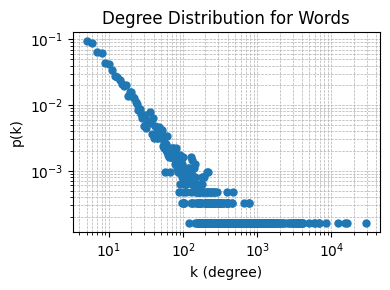

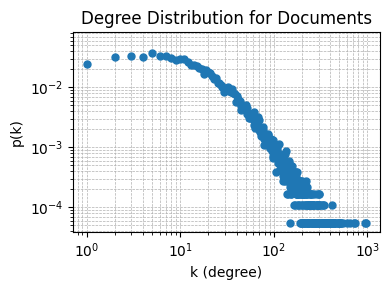

In [9]:
network.plot_degree_distribution(type='words')
network.plot_degree_distribution(type='documents')

--- Power-Law Analysis (words) ---
Gamma (scaling exponent): 2.0085
K_min (cutoff): 112.0


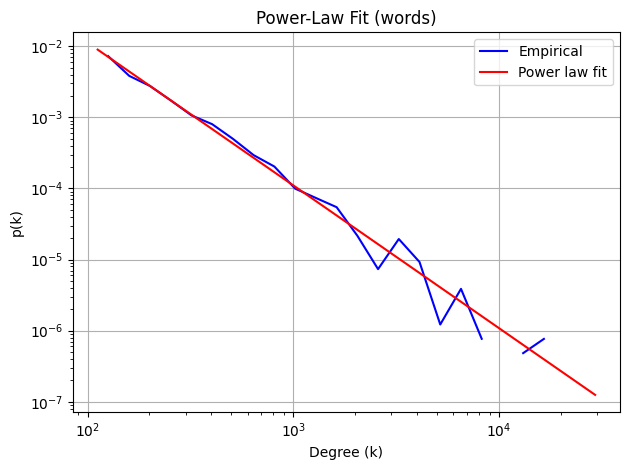

--- Power-Law Analysis (documents) ---
Gamma (scaling exponent): 3.9045
K_min (cutoff): 183.0


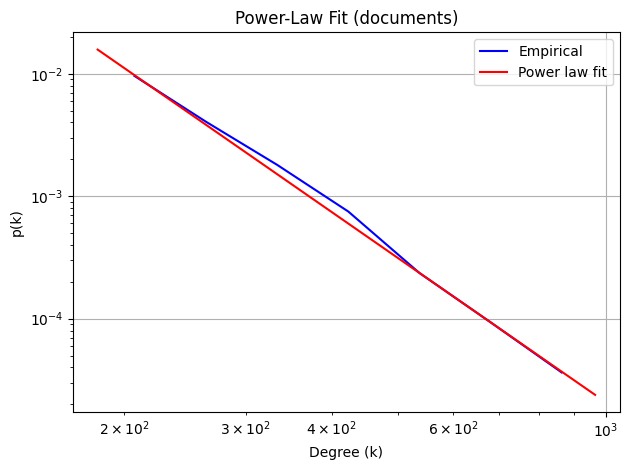

In [10]:
network.analyze_degree_distribution_powerlaw(type='words')
network.analyze_degree_distribution_powerlaw(type='documents')

## Build Projected Networks
Project the bipartite network onto words and documents.

### Word Projection

#### Network Community Profile
Use Local PageRank to calculate and plot the NCP.

In [29]:
word_projection = bn.to_igraph_projected(network, use='Pww', threshold=0.0)
print(f"Word-projected graph has {word_projection.vcount()} nodes and {word_projection.ecount()} edges.")

Word-projected graph has 6247 nodes and 2628289 edges.


In [ ]:
# Create thresholded graphs
word_proj_90 = ncp.threshold_graph(word_projection, 90)
word_proj_95 = ncp.threshold_graph(word_projection, 95)
word_proj_99 = ncp.threshold_graph(word_projection, 99)

In [ ]:
sizes = list(range(10, 1001, 50))
num_seeds = 10

In [ ]:
# 90th percentile
start_time = time.time()
ncp_90 = ncp.compute_ncp(word_proj_90, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

NCP computed for 20 sizes with 10 seeds in 259.46 seconds.


In [ ]:
# 95th percentile
start_time = time.time()
ncp_95 = ncp.compute_ncp(word_proj_95, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

NCP computed for 20 sizes with 10 seeds in 214.56 seconds.


In [77]:
# 99th percentile
start_time = time.time()
ncp_99 = ncp.compute_ncp(word_proj_99, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

KeyboardInterrupt: 

In [88]:
ncp.plot_ncp(ncp_90, ncp_95, ncp_99, sizes)

AttributeError: module 'ncp' has no attribute 'plot_ncp'

#### Build Network
Use 95th percentile threshold from NCP to build the WW graph.

In [99]:
word_g = ncp.threshold_graph(word_projection, 95)
print(f"Word-projected graph has {word_g.vcount()} nodes and {word_g.ecount()} edges.")
print(f"Graph is connected? {word_g.is_connected()}.")

Word-projected graph has 6247 nodes and 131415 edges.
Graph is connected? False.


In [100]:
# Basic stats
print(f"Average degree: {np.mean(word_g.degree()):.2f}")
print(f"Median degree: {np.median(word_g.degree()):.2f}")
components = word_g.connected_components()
print(f"Connected components: {len(components)}")

# Largest component
giant_component = components.giant()
print(f"Size of the giant component: {giant_component.vcount()}")

Average degree: 42.07
Median degree: 6.00
Connected components: 404
Size of the giant component: 5843


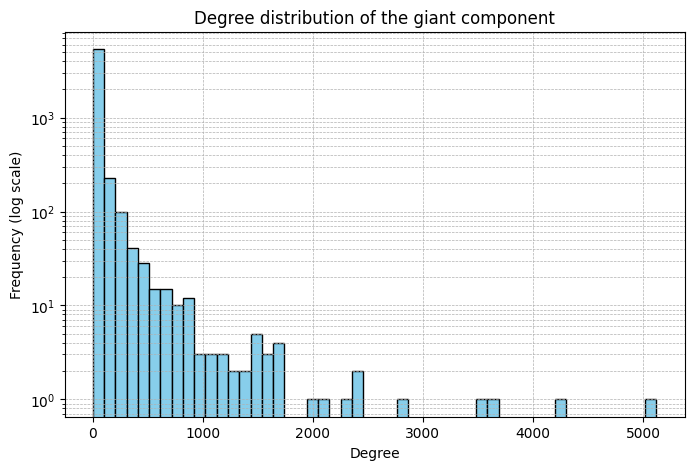

In [101]:
import matplotlib.pyplot as plt

# Get degree sequence
degree_sequence = giant_component.degree()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Degree')
plt.ylabel('Frequency (log scale)')
plt.title('Degree distribution of the giant component')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

In [105]:
def plot_giant_component_degree_distribution(giant_component):
    """
    Plot the degree distribution (on log-log scale) for the giant component of a graph.
    
    Parameters:
        graph (igraph.Graph): The input graph.
    
    Raises:
        ValueError: If the graph is empty or None.
    """
    if giant_component is None or giant_component.vcount() == 0:
        raise ValueError("Input graph is empty or None.")

    # Compute degrees
    degrees = np.array(giant_component.degree())

    # Degree histogram (normalized)
    k = np.unique(degrees)
    pk = np.histogram(degrees, bins=np.append(k, k[-1] + 1))[0]
    pk = pk / pk.sum()

    # Plot on log-log scale
    plt.figure(figsize=(4, 3))
    plt.loglog(k, pk, 'o', markersize=5, color='skyblue')
    plt.title("Degree Distribution (Giant Component)")
    plt.xlabel("k (degree)")
    plt.ylabel("p(k)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

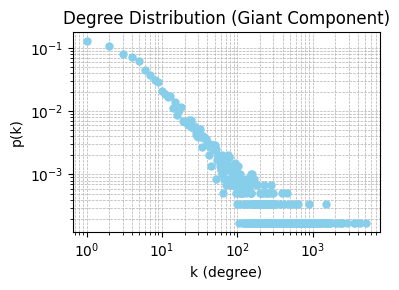

In [106]:
plot_giant_component_degree_distribution(giant_component)

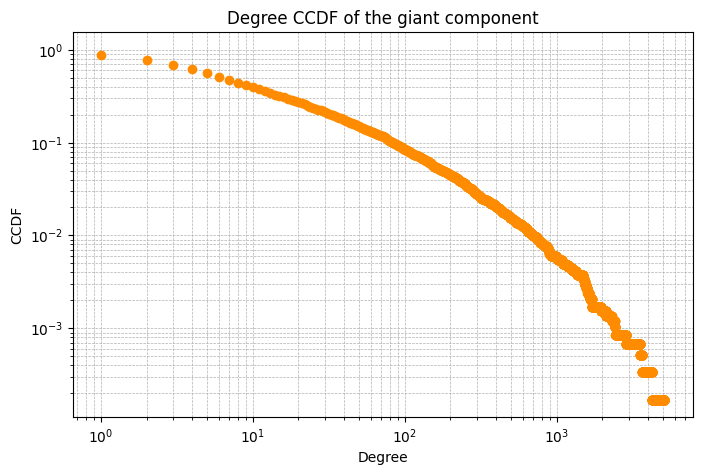

In [102]:
import numpy as np

# Sort degrees
degree_sequence = sorted(degree_sequence)
degree_counts = np.bincount(degree_sequence)
degree_values = np.arange(len(degree_counts))

# CCDF
ccdf = 1.0 - np.cumsum(degree_counts) / sum(degree_counts)

plt.figure(figsize=(8, 5))
plt.loglog(degree_values, ccdf, marker='o', linestyle='none', color='darkorange')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.title('Degree CCDF of the giant component')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

## Save to .gexf

In [ ]:
filename_b = RESULTS_GRAPHS_DIR / 'g_wd.gexf'
nx.write_gexf(G_bip_merged, filename_b)

In [ ]:
filename_w = RESULTS_GRAPHS_DIR / 'g_ww.gexf'
nx.write_gexf(G_merged_word, filename_w)

In [ ]:
filename_d = RESULTS_GRAPHS_DIR / 'g_dd.gexf'
nx.write_gexf(G_merged_word, filename_w)